In [1]:
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt

from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Helper functions

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

# Preparing Dataset

In [3]:
companyName = 'AMZN'
start_date = '2020-04-05'
end_date = '2023-04-05'
stock = fetch_ticker_data(companyName, start_date, end_date)

In [4]:
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7748\792272929.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock = stock.fillna(method="ffill", axis=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7748\792272929.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock = stock.fillna(method="bfill", axis=0)


In [14]:
stock.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2020-04-06 20:30:00,96.800003,99.926003,96.500999,99.879501,115464000
2020-04-07 20:30:00,100.855499,101.786003,99.880997,100.580002,102280000
2020-04-08 20:30:00,101.050003,102.199997,100.557503,102.150002,79546000
2020-04-09 20:30:00,102.214996,102.650002,100.883003,102.138000,92930000
2020-04-13 20:30:00,102.000000,109.000000,101.900002,108.443497,134334000


In [5]:
stock['Symbol'] = companyName
stock.tail()
#save a copy for later testing
original_stock = stock
original_symbol = companyName

stock['Close'].tail()

DateTime
2023-03-29 20:30:00    100.250000
2023-03-30 20:30:00    102.000000
2023-03-31 20:30:00    103.290001
2023-04-03 20:30:00    102.410004
2023-04-04 20:30:00    103.949997
Name: Close, dtype: float64

In [6]:
training_set = stock.iloc[:int(len(stock)*0.9),3:4].values 
test_set = stock.iloc[int(len(stock)*0.9):,3:4].values

test_set_return = stock.iloc[int(len(stock)*0.9):,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(679, 1)
(76, 1)


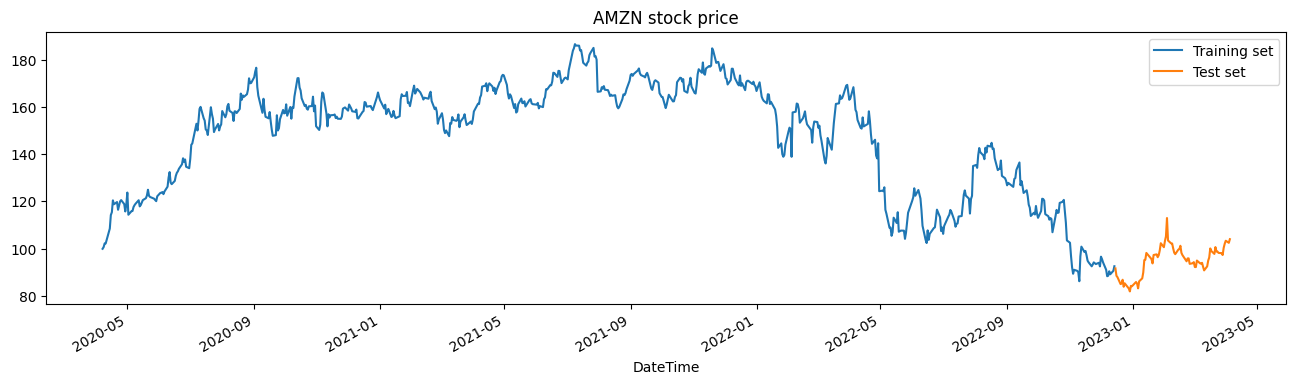

In [7]:
stock['Close'].iloc[:int(len(stock)*0.9)].plot(figsize=(16,4),legend=True)
stock['Close'].iloc[int(len(stock)*0.9):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set',f'Test set'])
plt.title(f'{companyName} stock price')
plt.show()

In [8]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[0.13680607 0.14378105 0.15941375 0.15929426 0.22207893 0.27905867
 0.29118649 0.34122604] 0.32470217552519354
[0.14378105 0.15941375 0.15929426 0.22207893 0.27905867 0.29118649
 0.34122604 0.32470218] 0.33396725188029497


In [10]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(671, 8) (671,)
(671, 8, 1) (671,)


In [11]:
print(x_train.shape, y_train.shape)
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(671, 8, 1) (671,)


# Building Transformer

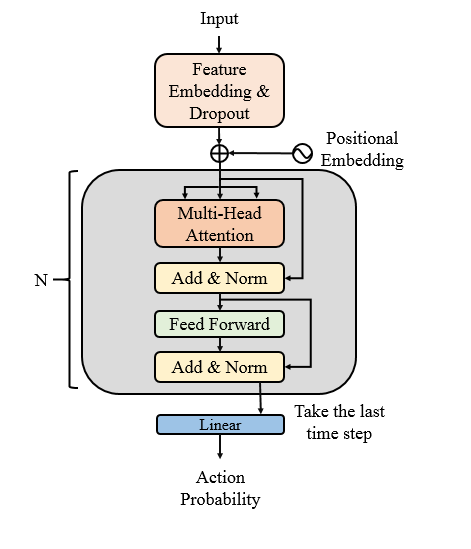

In [20]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [39]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x) #elu or relu
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [40]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [41]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [48]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [42]:
model = build_model(
    input_shape,
    head_size=128, # Embedding size for attention
    num_heads=4, # Number of attention heads
    ff_dim=2, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.10,
    dropout=0.10,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error",'mape'],
)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 8, 1)]               0         []                            
                                                                                                  
 layer_normalization_50 (La  (None, 8, 1)                 2         ['input_6[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_25 (M  (None, 8, 1)                 3585      ['layer_normalization_50[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_50

In [43]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/100
17/17 [==============================] - 30s 581ms/step - loss: 0.5170 - mean_squared_error: 0.5170 - mape: 1517.5414 - val_loss: 0.5021 - val_mean_squared_error: 0.5021 - val_mape: 108.0087 - lr: 1.0000e-06
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 0.4876 - mean_squared_error: 0.4876 - mape: 8371.8438 - val_loss: 0.4417 - val_mean_squared_error: 0.4417 - val_mape: 100.1302 - lr: 3.4300e-05
Epoch 3/100
17/17 [==============================] - 1s 32ms/step - loss: 0.4099 - mean_squared_error: 0.4099 - mape: 41154.0781 - val_loss: 0.3569 - val_mean_squared_error: 0.3569 - val_mape: 89.0852 - lr: 6.7600e-05
Epoch 4/100
17/17 [==============================] - 1s 44ms/step - loss: 0.3025 - mean_squared_error: 0.3025 - mape: 55275.3750 - val_loss: 0.2080 - val_mean_squared_error: 0.2080 - val_mape: 65.9597 - lr: 1.0090e-04
Epoch 5/100
17/17 [==============================] - 1s 33ms/step - loss: 0.1165 - mean_squared_error: 0.1165 - mape: 282877.0

# Results

3/3 [==============================] - 1s 10ms/step
[103.29000092] [102.41000366] [103.94999695]
[102.] [103.29000092] [102.41000366]
[102.43204]


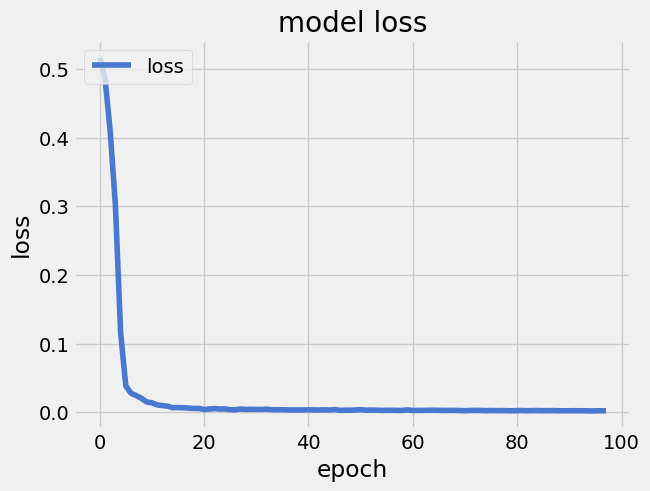

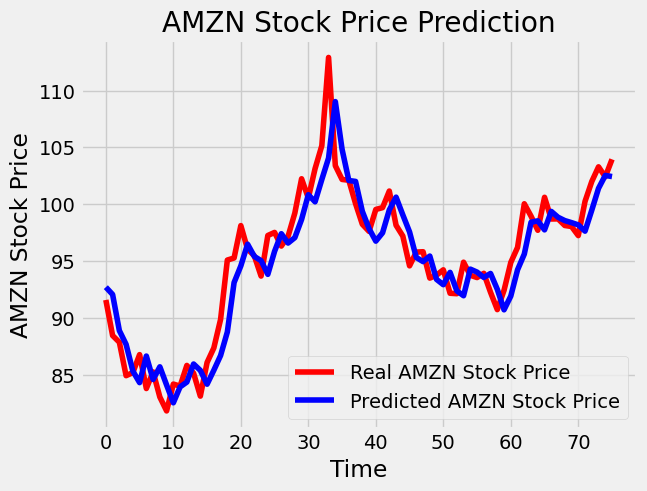

The root mean squared error is 2.392031145839208.


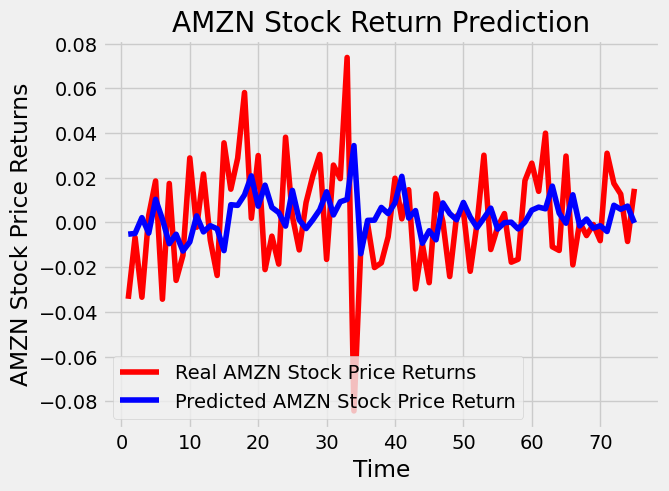

Stock price return:
The root mean squared error is 0.02628436469330275.


0.02628436469330275

In [44]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock['Close'].iloc[:int(len(stock)*0.9)],original_stock['Close'].iloc[int(len(stock)*0.9):]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model_2.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
print('Stock price return:')
return_rmse(test_set_return[1:], predicted_return[1:])

In [45]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(test_set, predicted_stock_price)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(test_set, predicted_stock_price)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(test_set, predicted_stock_price))}')
print(f'R2_Score: {metrics.r2_score(test_set, predicted_stock_price)}')
print(f'Mean Absolute Percentage Error: {metrics.mean_absolute_percentage_error(test_set, predicted_stock_price)}')

Mean Absolute Error: 1.8582379190545333
Mean Squared Error: 5.721813002664835
Root Mean Squared Error: 2.392031145839208
R2_Score: 0.8568735730686567
Mean Absolute Percentage Error: 0.019411894687562048


# Results (past observations)

3/3 [==============================] - 1s 70ms/step
[103.29000092] [102.41000366] [103.94999695]
[102.] [103.29000092] [102.41000366]
[102.66222]


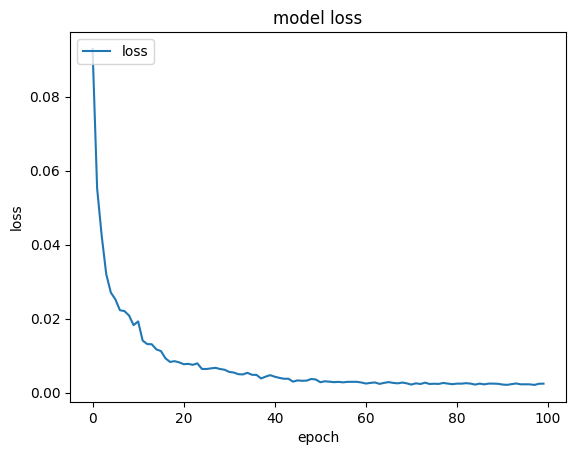

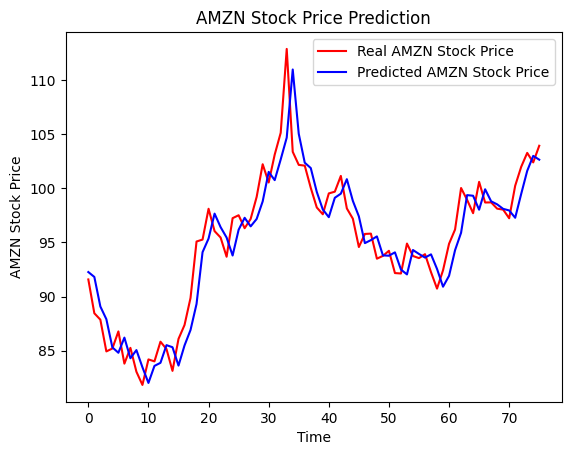

The root mean squared error is 2.34293916607489.


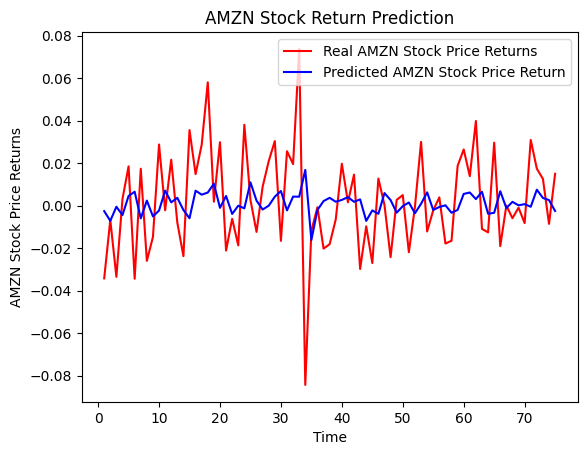

Stock price return:
The root mean squared error is 0.025040791850988186.


0.025040791850988186

In [23]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock['Close'].iloc[:int(len(stock)*0.9)],original_stock['Close'].iloc[int(len(stock)*0.9):]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
print('Stock price return:')
return_rmse(test_set_return[1:], predicted_return[1:])

3/3 [==============================] - 0s 44ms/step
[103.29000092] [102.41000366] [103.94999695]
[102.] [103.29000092] [102.41000366]
[101.83383]


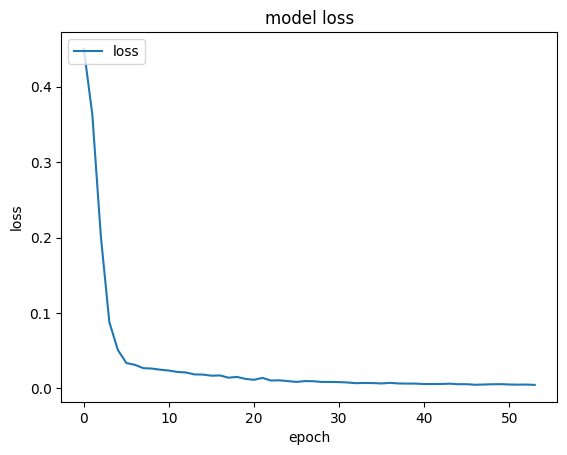

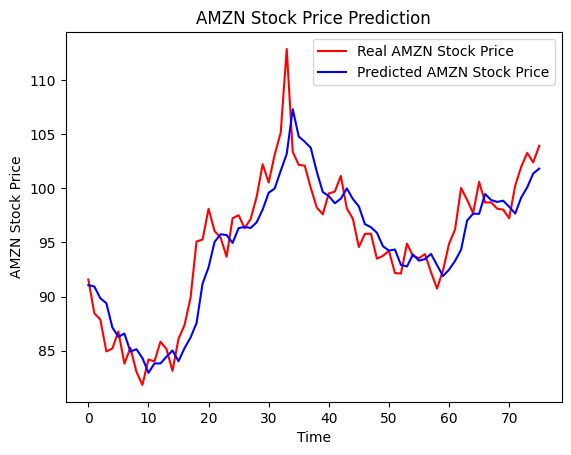

The root mean squared error is 2.670184771829409.


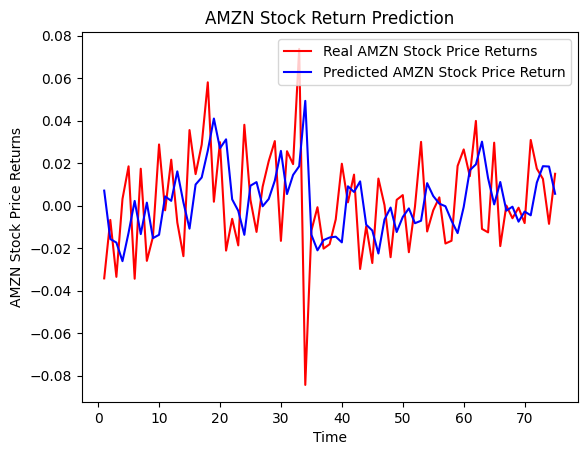

Stock price return:
The root mean squared error is 0.02899615949819712.


0.02899615949819712

In [81]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock['Close'].iloc[:int(len(stock)*0.9)],original_stock['Close'].iloc[int(len(stock)*0.9):]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
print('Stock price return:')
return_rmse(test_set_return[1:], predicted_return[1:])

In [24]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(test_set, predicted_stock_price)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(test_set, predicted_stock_price)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(test_set, predicted_stock_price))}')
print(f'R2_Score: {metrics.r2_score(test_set, predicted_stock_price)}')
print(f'Mean Absolute Percentage Error: {metrics.mean_absolute_percentage_error(test_set, predicted_stock_price)}')

Mean Absolute Error: 1.821447673596834
Mean Squared Error: 5.4893639359277016
Root Mean Squared Error: 2.34293916607489
R2_Score: 0.8626880945062005
Mean Absolute Percentage Error: 0.019018581455181954


In [80]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(test_set, predicted_stock_price)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(test_set, predicted_stock_price)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(test_set, predicted_stock_price))}')
print(f'R2_Score: {metrics.r2_score(test_set, predicted_stock_price)}')
print(f'Mean Absolute Percentage Error: {metrics.mean_absolute_percentage_error(test_set, predicted_stock_price)}')

Mean Absolute Error: 2.0685284263209294
Mean Squared Error: 7.129886715709673
Root Mean Squared Error: 2.670184771829409
R2_Score: 0.8216517719873917
Mean Absolute Percentage Error: 0.02153766935052496


3/3 [==============================] - 2s 182ms/step
[103.29000092] [102.41000366] [103.94999695]
[102.] [103.29000092] [102.41000366]
[101.85428]


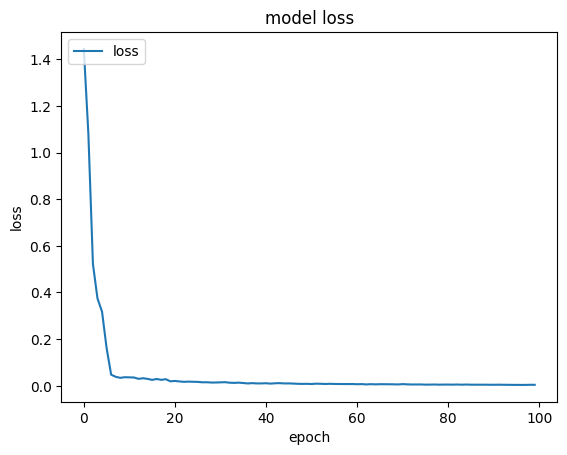

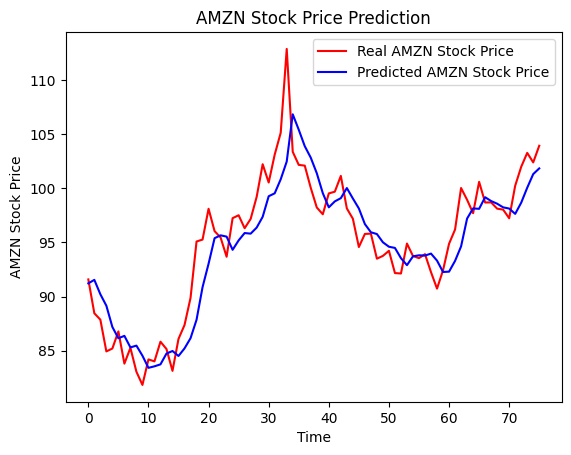

The root mean squared error is 2.7384355859719056.


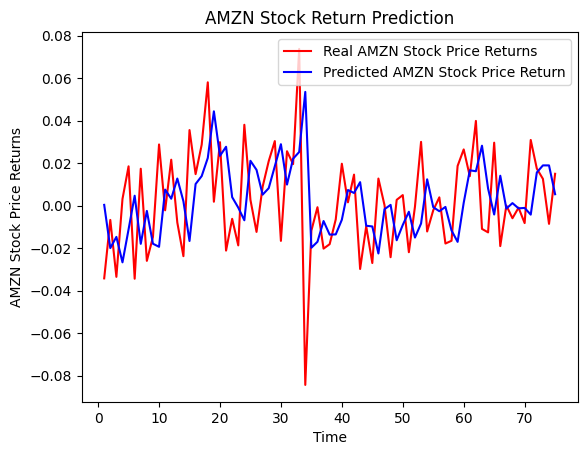

The root mean squared error is 0.029315945374416955.


0.029315945374416955

In [63]:
# Test for time_step 20

dataset_total = pd.concat((original_stock['Close'].iloc[:int(len(stock)*0.9)],original_stock['Close'].iloc[int(len(stock)*0.9):]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])

In [34]:
stock.reset_index(inplace=True)
stock.head()

,DateTime,Open,High,Low,Close,Volume,Symbol
0,2020-04-06 20:30:00,96.800003,99.926003,96.500999,99.879501,115464000,AMZN
1,2020-04-07 20:30:00,100.855499,101.786003,99.880997,100.580002,102280000,AMZN
2,2020-04-08 20:30:00,101.050003,102.199997,100.557503,102.150002,79546000,AMZN
3,2020-04-09 20:30:00,102.214996,102.650002,100.883003,102.138000,92930000,AMZN
4,2020-04-13 20:30:00,102.000000,109.000000,101.900002,108.443497,134334000,AMZN


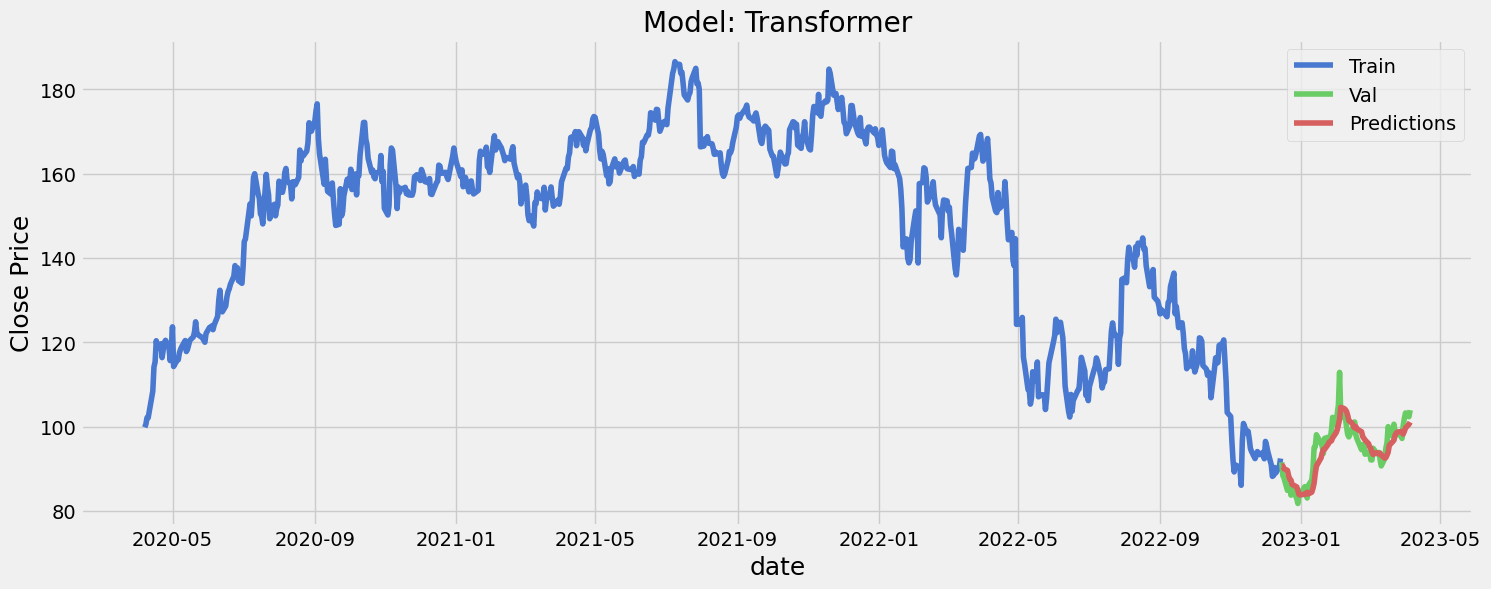

In [36]:
new_dataset_length = int(len(stock)*0.9)
plt.style.use("fivethirtyeight")
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = stock.filter(['Close'])[:new_dataset_length]
valid = stock.filter(['Close'])[new_dataset_length:]
valid['PredictionsTransformer'] = predicted_stock_price

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model: Transformer')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(stock['DateTime'].iloc[:new_dataset_length],train['Close'])
plt.plot(stock['DateTime'].iloc[new_dataset_length:],valid[['Close', 'PredictionsTransformer']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()

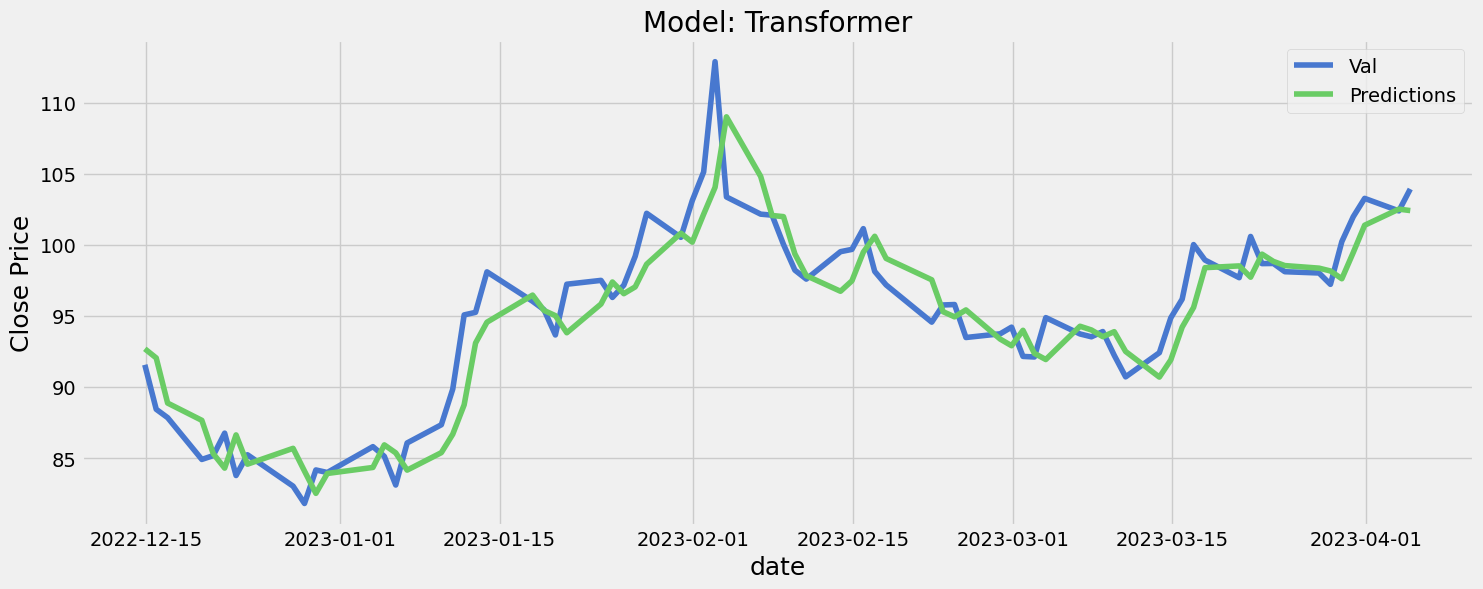

In [46]:
new_dataset_length = int(len(stock)*0.9)
plt.style.use("fivethirtyeight")
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = stock.filter(['Close'])[:new_dataset_length]
valid = stock.filter(['Close'])[new_dataset_length:]
valid['PredictionsTransformer'] = predicted_stock_price

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model: Transformer')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
#plt.plot(stock['DateTime'].iloc[:new_dataset_length],train['Close'])
plt.plot(stock['DateTime'].iloc[new_dataset_length:],valid[['Close', 'PredictionsTransformer']])
plt.legend(['Val', 'Predictions'], loc='best')
plt.show()